In [1]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 39.7 MB/s eta 0:00:0000:0100:01


In [2]:
"""
Hackathon - INCAP - IconPro GmbH
Timeseries Classification with Transformers
"""
import pandas as pd
from tensorflow import keras
from dataclasses import dataclass
from tensorflow.keras import layers
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.rocket import Rocket, MiniRocket
import matplotlib.pyplot as plt
# Import packages as you need

In [3]:
def load_data(data_path):
    """
    Loading of the dataset provided
    Edit the code below
    """
    data = pd.read_pickle(data_path)
    return data

In [4]:
def preprocess_data(data):
    """
    A standard nan removal to be added.
    Add more preprocessing steps if needed.
    """
    
    X = data['dim_0'].apply(lambda x: x.reshape(500,1))
    
    for i in range(data.shape[0]):
        if True in np.isnan(data['dim_0'][i]).flatten():
            print(i)
            
    input_x = []
    for array in X:
        input_x.append(array)
    
#     X = pd.DataFrame(data.dim_0.tolist())
#     X = X.to_numpy()
    
    y = data['labels']
    y = y.astype(int)
    y[y == -1] = 0
    return input_x,y

In [5]:
def Rocket_preprocessing(input_x):
    input_x1=[]
    input_x = np.array(input_x).reshape(4921, 500)
    for i in range(input_x.shape[0]):
        input_x1.append(pd.Series(input_x[i]))
    input_x1=pd.Series(input_x1)
    
    input_x1=pd.DataFrame(input_x1)
    return input_x1

In [6]:
def split_train_test(X, y):
    """
    Splitting the data into train, test, validation 
    """
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
def Rocket(X_train, X_val, X_test):
    rocket = MiniRocket(num_kernels=500)  # by default, ROCKET uses 10,000 kernels
    X_train = rocket.fit_transform(X_train)
    X_train = np.expand_dims(np.array(X_train), axis=2)
    
    X_val = rocket.transform(X_val)
    X_val = np.expand_dims(np.array(X_val), axis=2)
    
    X_test = rocket.transform(X_test)
    X_test = np.expand_dims(np.array(X_test), axis=2)
    
    return X_train, X_val, X_test

In [8]:
def normalization(X_train, X_val, X_test):
    scaler = StandardScaler()
    shp = X_train.shape[1]
    X_train = np.reshape(X_train, (-1,shp))
    X_val = np.reshape(X_val, (-1,shp))
    X_test = np.reshape(X_test, (-1,shp))
    
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return np.reshape(X_train, (-1,shp,1)), np.reshape(X_val, (-1,shp,1)), np.reshape(X_test, (-1,shp,1))

In [9]:
def timeseries_transform(data, head_size, num_heads, ff_dim, dropout=0):
    """
    Implement the timeseries transformer here
    """
    # Normalization and Attention
    x = data
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(dropout)(x)
    res = x + data

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=data.shape[-1], kernel_size=1)(x)
    return x + res

In [10]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = timeseries_transform(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(2, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [11]:
def model_training(X_train, y_train, X_val, y_val):
    """
    Train the data with the compatible model
    """
    
    input_shape = X_train.shape[1:]

    model = build_model(input_shape, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[256], mlp_dropout=0.4, dropout=0.25)
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.85)

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=["sparse_categorical_accuracy"],
    )
    
    model.summary()

    callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

    history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=100, batch_size=128, callbacks=callbacks)
    
    plotting(history)
    
    return model

In [12]:
def metric(y_act, y_pred):
    """
    Standard metrics and plotting should be same
    Metrics should be computed on validation data(unseen data)
    1. Balanced accuracy score
    2. Confusion matrix
    3. Per-class accuracy
    """
    
    cm = metrics.confusion_matrix(y_act, y_pred)
    balanced_accuracy = metrics.balanced_accuracy_score(y_act, y_pred)
    
    return cm, balanced_accuracy

In [13]:
def validation(X_val, y_val, metrics):
    """
    Comparing the results with provided Series Embedder
    Plot confusion matrices of self analysis and LSTM with balanced_accuracy
    
    """
    
    score = model.evaluate(X_val, y_val, verbose=1)
    
    return score

In [14]:
def evaluate(X_test, y_act, metric, model):
    y_pred = model.predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred, axis=1)
    cm, ba = metric(y_act, y_pred)
    
    return y_pred, cm, ba

In [15]:
def plotting(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.figure(figsize=(10,10))
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('sparse_categorical_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [16]:
path = "../input/fordadata/data.pkl"
data = load_data(path)
X, y = preprocess_data(data)
X = Rocket_preprocessing(X)

X_train, X_val, X_test, y_train, y_val, y_test = split_train_test(X, y)
X_train, X_val, X_test = Rocket(X_train, X_val, X_test)
X_train, X_val, X_test = normalization(X_train, X_val, X_test)

2022-05-22 04:28:18.504699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 04:28:18.660408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 04:28:18.661383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 04:28:18.662816: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 420, 1)]     0                                            
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 420, 1)       7169        input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 420, 1)       2           multi_head_attention[0][0]       
__________________________________________________________________________________________________
dropout (Dropout)               (None, 420, 1)       0           layer_normalization[0][0]    

2022-05-22 04:28:21.715035: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-22 04:28:27.111472: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


25/25 [==============================] - 22s 477ms/step - loss: 0.7815 - sparse_categorical_accuracy: 0.6147 - val_loss: 0.4332 - val_sparse_categorical_accuracy: 0.8000
Epoch 2/100
25/25 [==============================] - 11s 457ms/step - loss: 0.4368 - sparse_categorical_accuracy: 0.7983 - val_loss: 0.3010 - val_sparse_categorical_accuracy: 0.8741
Epoch 3/100
25/25 [==============================] - 11s 457ms/step - loss: 0.3533 - sparse_categorical_accuracy: 0.8558 - val_loss: 0.2589 - val_sparse_categorical_accuracy: 0.8843
Epoch 4/100
25/25 [==============================] - 11s 457ms/step - loss: 0.2975 - sparse_categorical_accuracy: 0.8783 - val_loss: 0.2376 - val_sparse_categorical_accuracy: 0.8944
Epoch 5/100
25/25 [==============================] - 11s 457ms/step - loss: 0.2652 - sparse_categorical_accuracy: 0.8914 - val_loss: 0.2210 - val_sparse_categorical_accuracy: 0.9046
Epoch 6/100
25/25 [==============================] - 11s 456ms/step - loss: 0.2586 - sparse_categorica

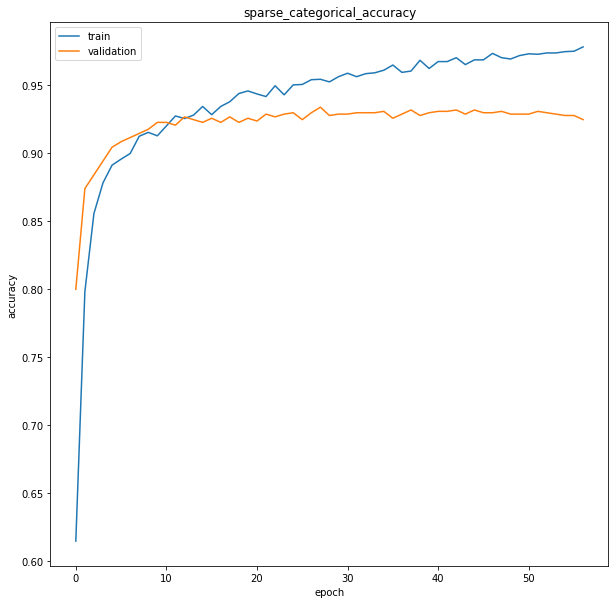

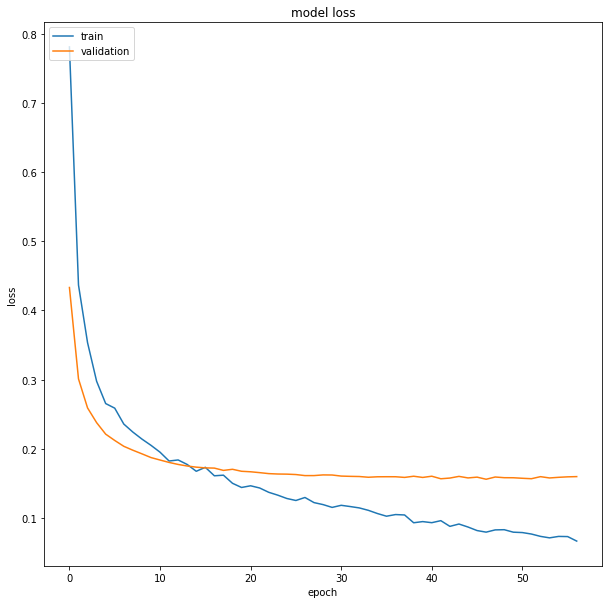

In [17]:
model_self=model_training(X_train, y_train, X_val, y_val)

In [18]:
y_pred, conf_mat, bal_acc = evaluate(X_test, y_test, metric, model_self)

25/25 [==============================] - 1s 37ms/step


In [19]:
model_self.save("transformer_banana_muffin_normalized")
!zip -r transformer_normalized.zip "/kaggle/working/transformer_banana_muffin_normalized
model_self.save("transformer_banana_muffin_normalized.h5")
!zip -r transformer_normalized.zip "/kaggle/working/transformer_banana_muffin_normalized"

2022-05-22 04:39:26.482959: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file
  adding: kaggle/working/transformer_banana_muffin_normalized/ (stored 0%)
  adding: kaggle/working/transformer_banana_muffin_normalized/variables/ (stored 0%)
  adding: kaggle/working/transformer_banana_muffin_normalized/variables/variables.index (deflated 84%)
  adding: kaggle/working/transformer_banana_muffin_normalized/variables/variables.data-00000-of-00001 (deflated 25%)
  adding: kaggle/working/transformer_banana_muffin_normalized/keras_metadata.pb (deflated 95%)
  adding: kaggle/working/transformer_banana_muffin_normalized/saved_model.pb (deflated 90%)
  adding: kaggle/working/transformer_banana_muffin_normalized/assets/ (stored 0%)


In [20]:
import plotly.figure_factory as ff
import plotly.express as px

x = ['1', '-1']
y =  ['1', '-1']

# change each element of z to type string for annotations
z_text = [[str(y) for y in x] for x in conf_mat]

# set up figure 
fig = px.imshow(conf_mat, x=x, y=y, color_continuous_scale='Viridis', aspect="auto")
fig.update_traces(text=z_text, texttemplate="%{text}")

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>', title_font=dict(color="black",size=20),
                  title_x=0.5, title_y=0.95)

# # add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=20), x=0.5, y=-0.15, showarrow=False,
                        text="Predicted value", xref="paper", yref="paper"))

# # add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=20), x=-0.05, y=0.5, showarrow=False,
                        text="Real value", textangle=-90, xref="paper", yref="paper"))

fig.show()

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [21]:
# metrics=metric(val,model_self)

# lstm_cm,lstm_balanced_accuracy=lstm(preprocessed_data,target='labels')
# metrics_validation = [lstm_cm, lstm_balanced_accuracy]
# validation(metrics,metrics_validation)